<a href="https://colab.research.google.com/github/EagleAdelaide/TimeSeries_Forcasting/blob/main/TimeSeries_Exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[*********************100%***********************]  1 of 1 completed


<Figure size 1200x600 with 0 Axes>

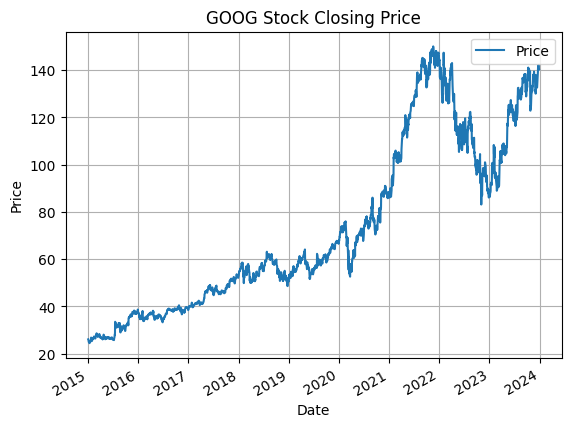

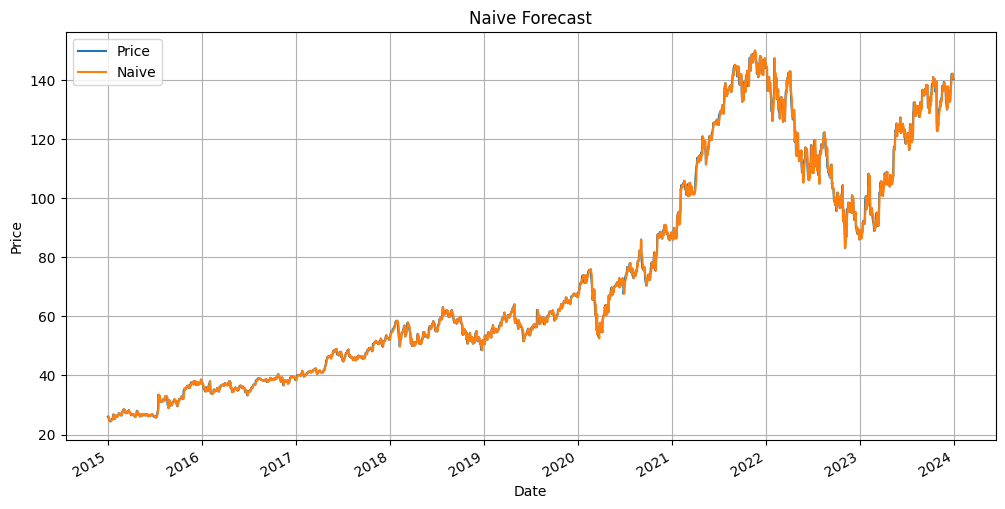

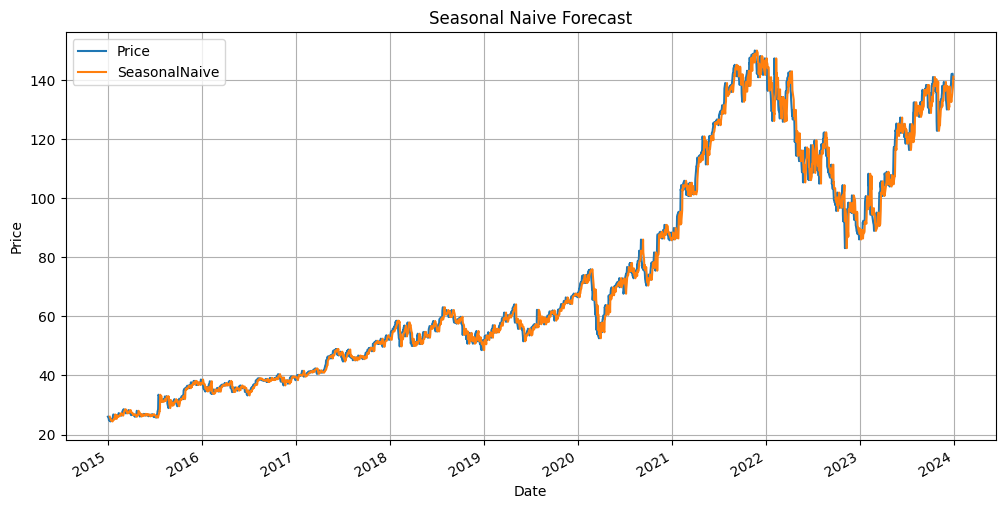

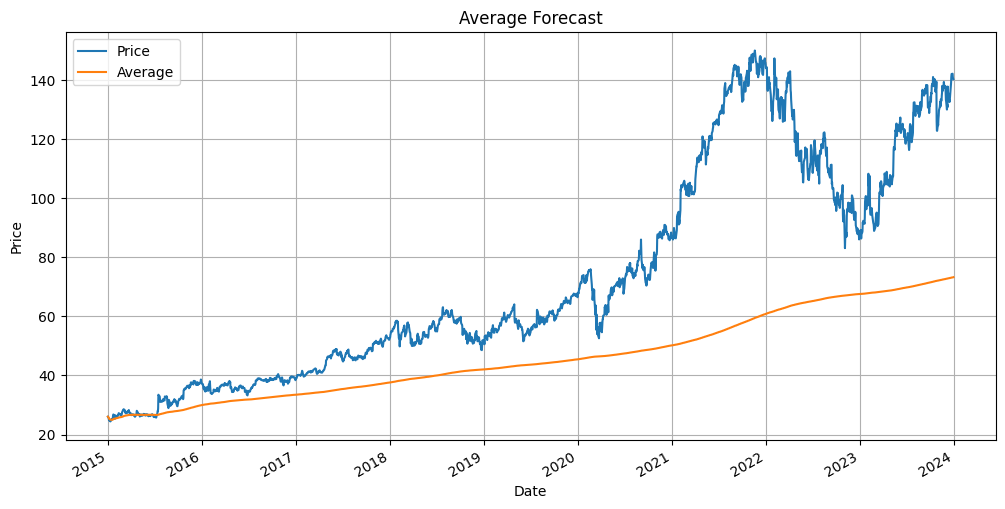

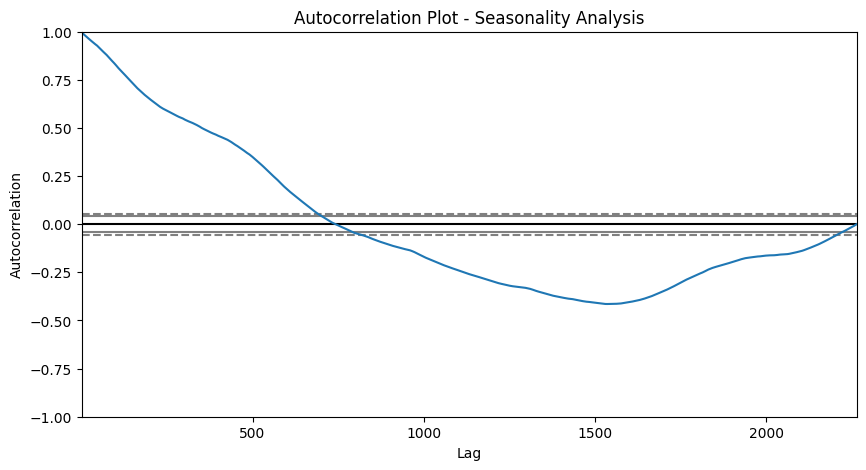

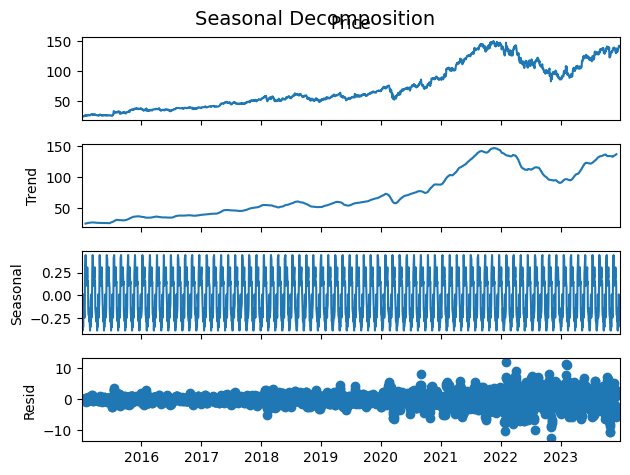

ADF Statistic: -0.13728174670350426
p-value: 0.9455961762665798

Series is NOT stationary. Differencing applied.



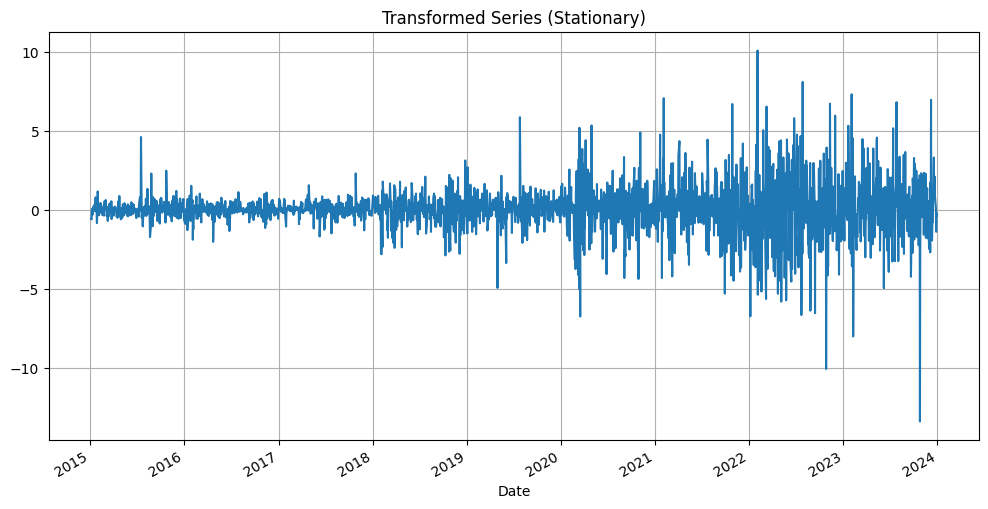

<Figure size 1200x600 with 0 Axes>

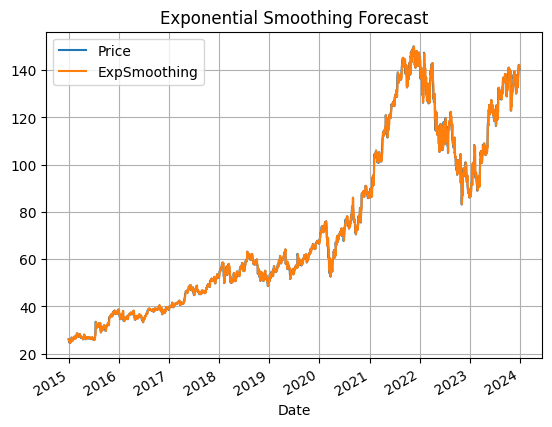

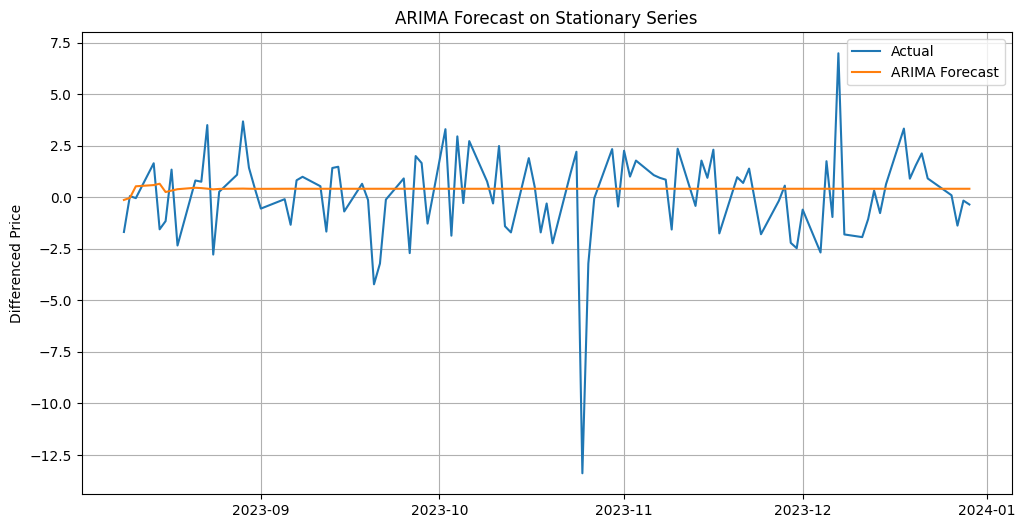

Epoch 1/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.1134
Epoch 2/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0010
Epoch 3/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 5.9873e-04
Epoch 4/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 5.4035e-04
Epoch 5/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 5.2679e-04
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


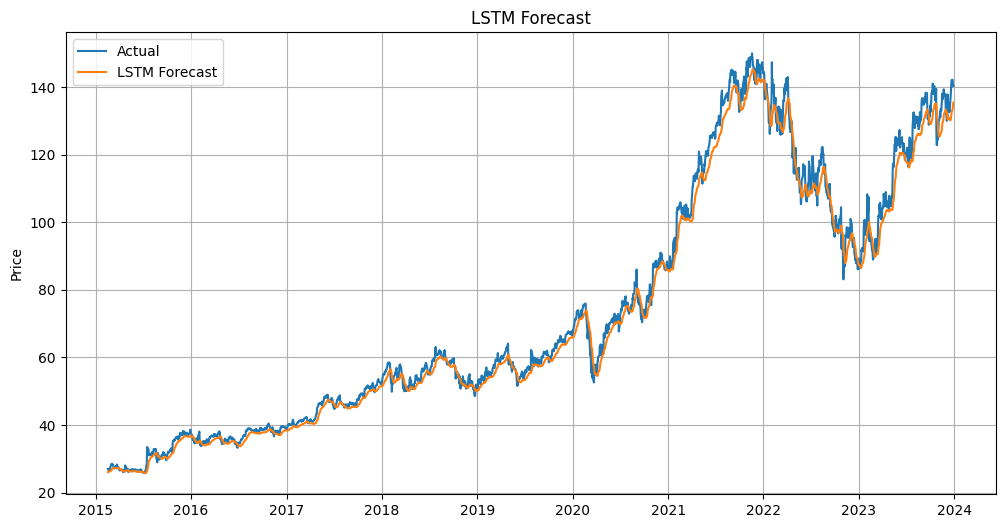

[*********************100%***********************]  1 of 1 completed


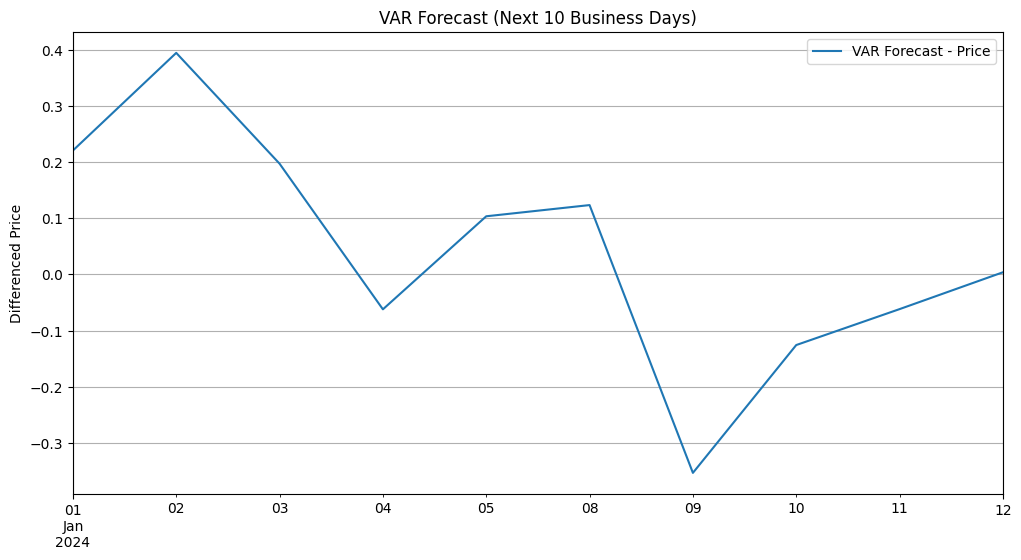

In [2]:
# Time Series Forecasting: Google Stock Data (GOOG)

# 1. SETUP AND DATA DOWNLOAD
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.api import VAR
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Download Google stock price data
data = yf.download('GOOG', start='2015-01-01', end='2024-01-01')
data = data[['Close']].dropna()
data.columns = ['Price']

plt.figure(figsize=(12, 6))
data.plot(title='GOOG Stock Closing Price', legend=True)
plt.ylabel("Price")
plt.grid()
plt.show()

# 2. NAIVE FORECAST
data['Naive'] = data['Price'].shift(1)
data[['Price', 'Naive']].plot(title='Naive Forecast', figsize=(12, 6))
plt.ylabel("Price")
plt.grid()
plt.show()

# 3. SEASONAL NAIVE FORECAST
season_length = 5  # assuming weekly seasonality

data['SeasonalNaive'] = data['Price'].shift(season_length)
data[['Price', 'SeasonalNaive']].plot(title='Seasonal Naive Forecast', figsize=(12, 6))
plt.ylabel("Price")
plt.grid()
plt.show()

# 4. AVERAGE FORECAST
data['Average'] = data['Price'].expanding().mean()
data[['Price', 'Average']].plot(title='Average Forecast', figsize=(12, 6))
plt.ylabel("Price")
plt.grid()
plt.show()

# 5. SEASONALITY ANALYSIS
from pandas.plotting import autocorrelation_plot

plt.figure(figsize=(10, 5))
autocorrelation_plot(data['Price'])
plt.title("Autocorrelation Plot - Seasonality Analysis")
plt.grid()
plt.show()

# 6. DECOMPOSITION
result = seasonal_decompose(data['Price'], model='additive', period=30)
result.plot()
plt.suptitle("Seasonal Decomposition", fontsize=14)
plt.show()

# 7. STATIONARITY CHECK
result_adf = adfuller(data['Price'].dropna())
print("ADF Statistic:", result_adf[0])
print("p-value:", result_adf[1])

if result_adf[1] > 0.05:
    print("\nSeries is NOT stationary. Differencing applied.\n")
    data['Price_diff'] = data['Price'].diff().dropna()
else:
    print("\nSeries is stationary.\n")
    data['Price_diff'] = data['Price']

plt.figure(figsize=(12, 6))
data['Price_diff'].dropna().plot(title="Transformed Series (Stationary)")
plt.grid()
plt.show()

# 8. EXPONENTIAL SMOOTHING
model_exp = ExponentialSmoothing(data['Price'], trend='add', seasonal=None)
fit_exp = model_exp.fit()
data['ExpSmoothing'] = fit_exp.fittedvalues

plt.figure(figsize=(12, 6))
data[['Price', 'ExpSmoothing']].plot(title='Exponential Smoothing Forecast')
plt.grid()
plt.show()

# 9. ARIMA MODELING
train = data['Price_diff'].dropna()[:-100]
test = data['Price_diff'].dropna()[-100:]

model_arima = ARIMA(train, order=(5, 1, 0))
fit_arima = model_arima.fit()
pred_arima = fit_arima.forecast(steps=100)

plt.figure(figsize=(12, 6))
plt.plot(test.index, test.values, label='Actual')
plt.plot(test.index, pred_arima, label='ARIMA Forecast')
plt.title("ARIMA Forecast on Stationary Series")
plt.ylabel("Differenced Price")
plt.legend()
plt.grid()
plt.show()

# 10. LSTM FORECAST
# Normalize data
scaler = MinMaxScaler()
data['Scaled'] = scaler.fit_transform(data[['Price']])

# Sequence data
def create_sequences(data, seq_length):
    x, y = [], []
    for i in range(len(data)-seq_length):
        x.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(x), np.array(y)

seq_len = 30
seq_data = data['Scaled'].dropna().values
X, y = create_sequences(seq_data, seq_len)
X = X.reshape((X.shape[0], X.shape[1], 1))

model_lstm = Sequential([
    LSTM(50, activation='relu', input_shape=(seq_len, 1)),
    Dense(1)
])
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(X, y, epochs=5, verbose=1)

preds = model_lstm.predict(X)
preds_inv = scaler.inverse_transform(preds)

plt.figure(figsize=(12, 6))
plt.plot(data.index[seq_len:], data['Price'].values[seq_len:], label='Actual')
plt.plot(data.index[seq_len:], preds_inv, label='LSTM Forecast')
plt.title("LSTM Forecast")
plt.ylabel("Price")
plt.legend()
plt.grid()
plt.show()

# 11. MULTIVARIATE TIME SERIES (e.g. with Volume)
data_multi = yf.download('GOOG', start='2015-01-01', end='2024-01-01')[['Close', 'Volume']].dropna()
data_multi.columns = ['Price', 'Volume']
data_multi = data_multi.diff().dropna()

# 12. VAR MODEL
model_var = VAR(data_multi)
fit_var = model_var.fit(maxlags=15, ic='aic')
pred_var = fit_var.forecast(fit_var.endog, steps=10)

forecast_index = pd.date_range(start=data_multi.index[-1], periods=11, freq='B')[1:]
forecast_df = pd.DataFrame(pred_var, index=forecast_index, columns=['Price', 'Volume'])

plt.figure(figsize=(12, 6))
forecast_df['Price'].plot(label='VAR Forecast - Price')
plt.title("VAR Forecast (Next 10 Business Days)")
plt.ylabel("Differenced Price")
plt.grid()
plt.legend()
plt.show()

[*********************100%***********************]  1 of 1 completed


<Figure size 1200x600 with 0 Axes>

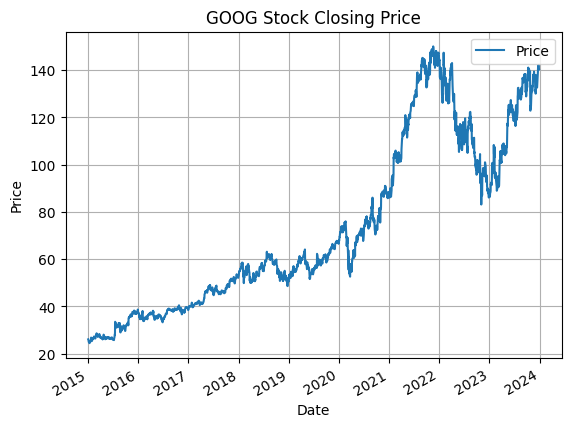

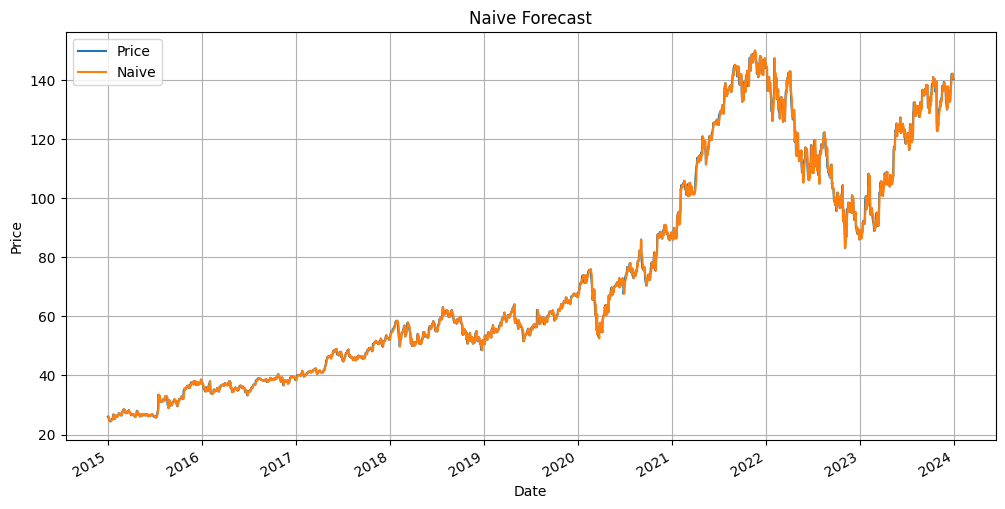

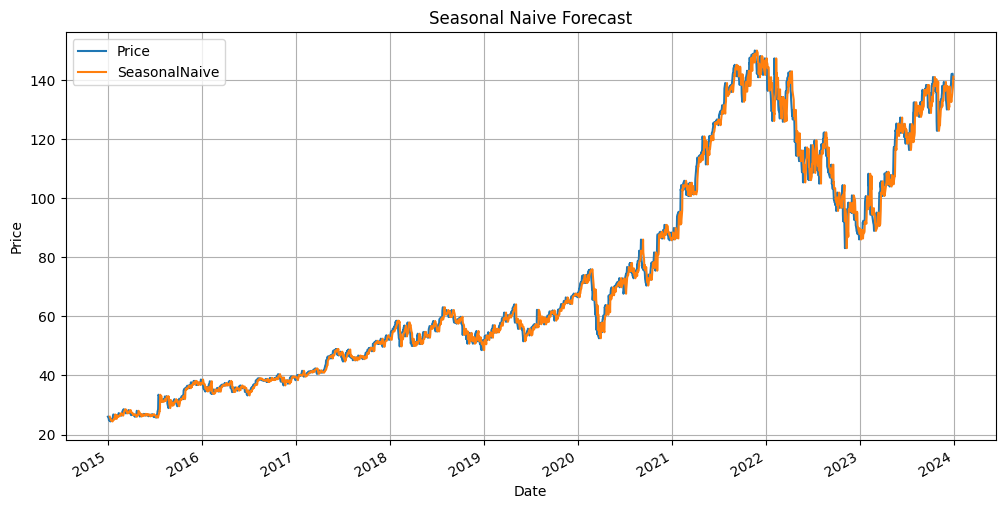

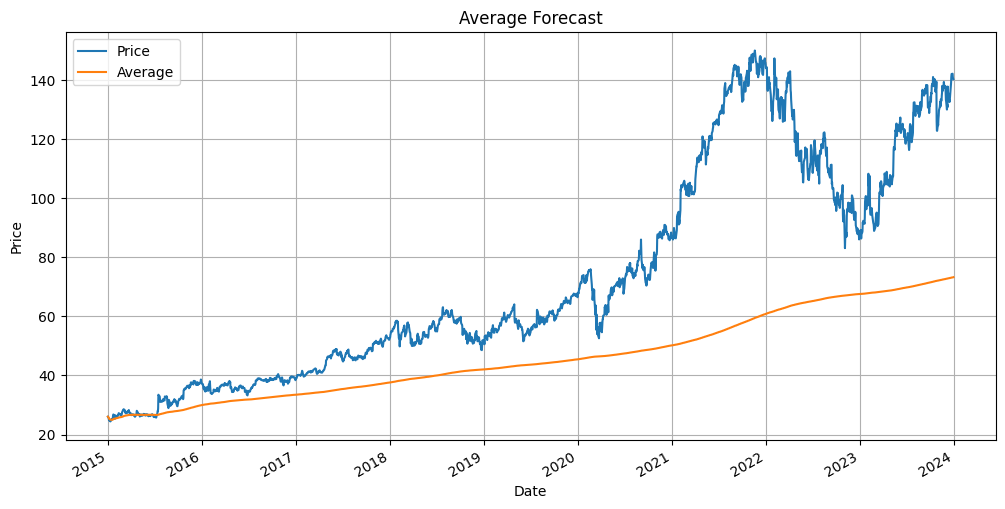

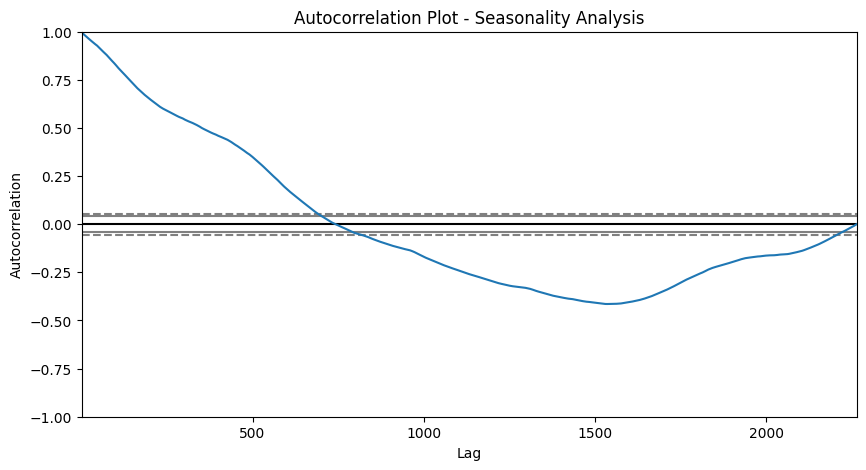

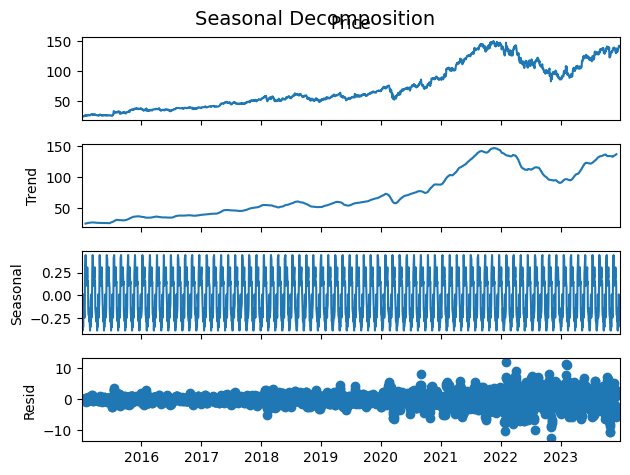

ADF Statistic: -0.13728174670350426
p-value: 0.9455961762665798

Series is NOT stationary. Differencing applied.



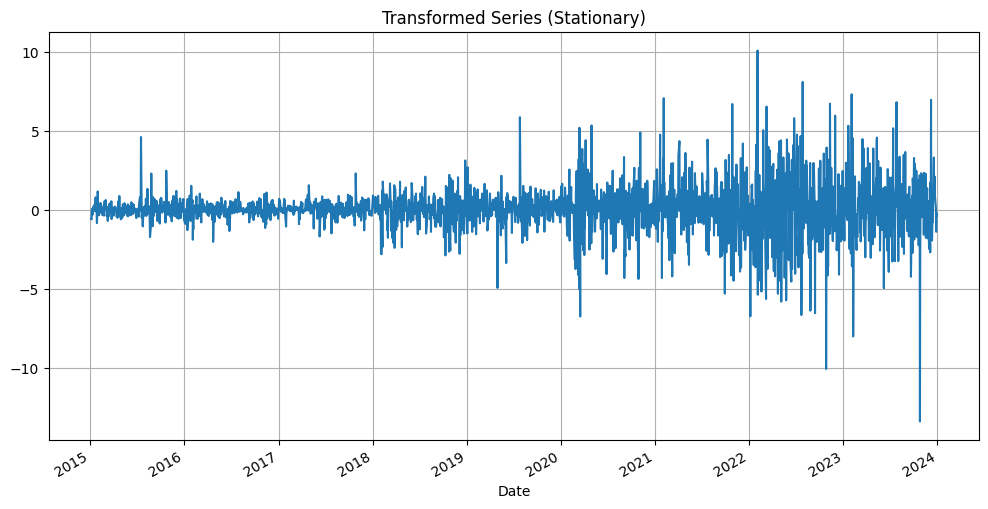

<Figure size 1200x500 with 0 Axes>

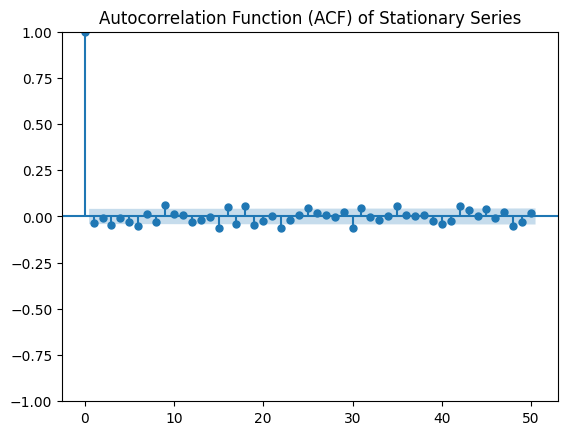

<Figure size 1200x500 with 0 Axes>

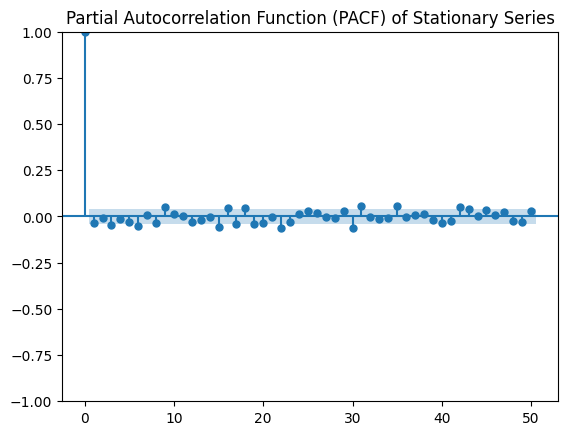

<Figure size 1200x600 with 0 Axes>

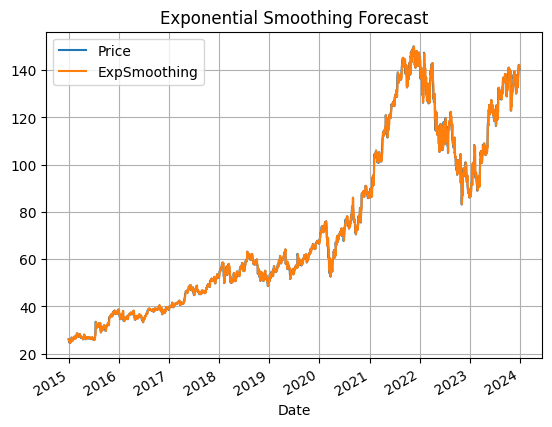

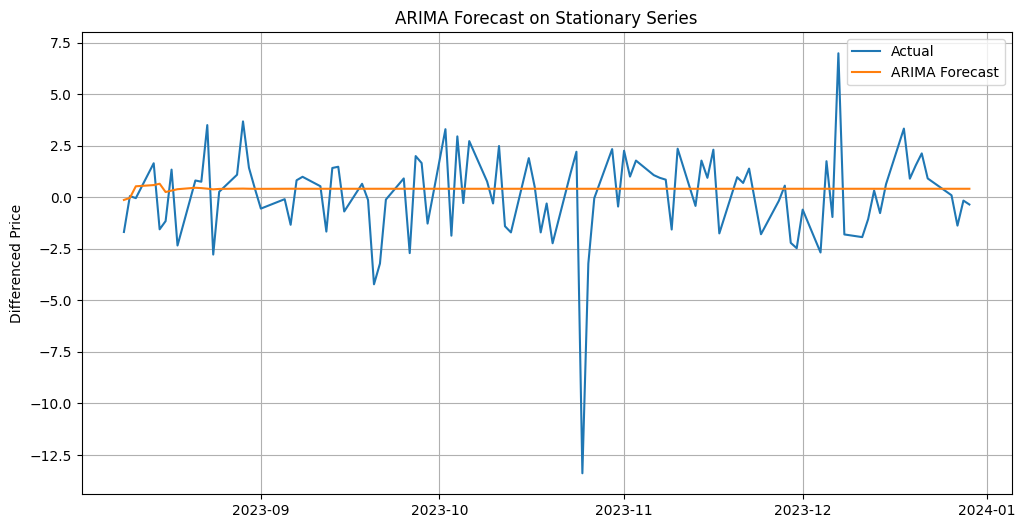

Epoch 1/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - loss: 0.2172
Epoch 2/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0025
Epoch 3/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0010
Epoch 4/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 7.0980e-04
Epoch 5/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 6.1227e-04
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


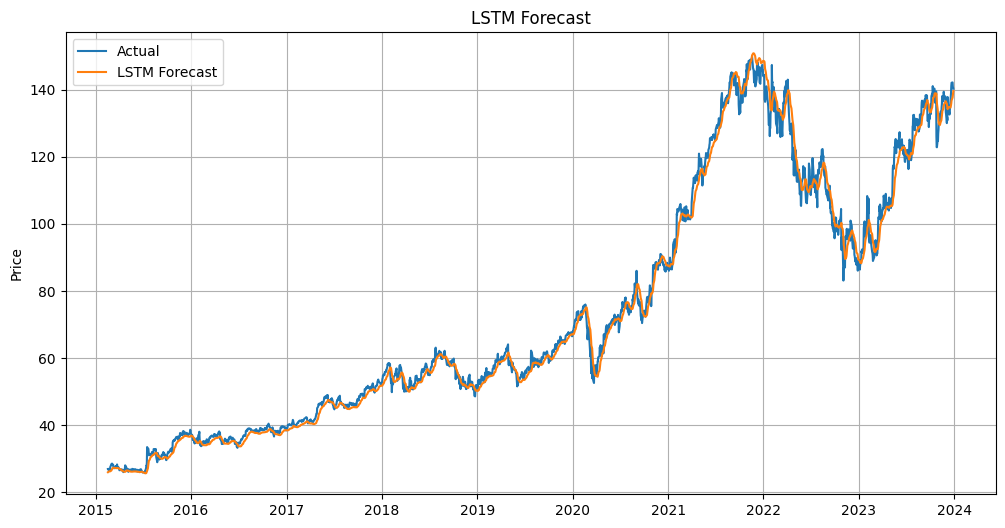

[*********************100%***********************]  1 of 1 completed


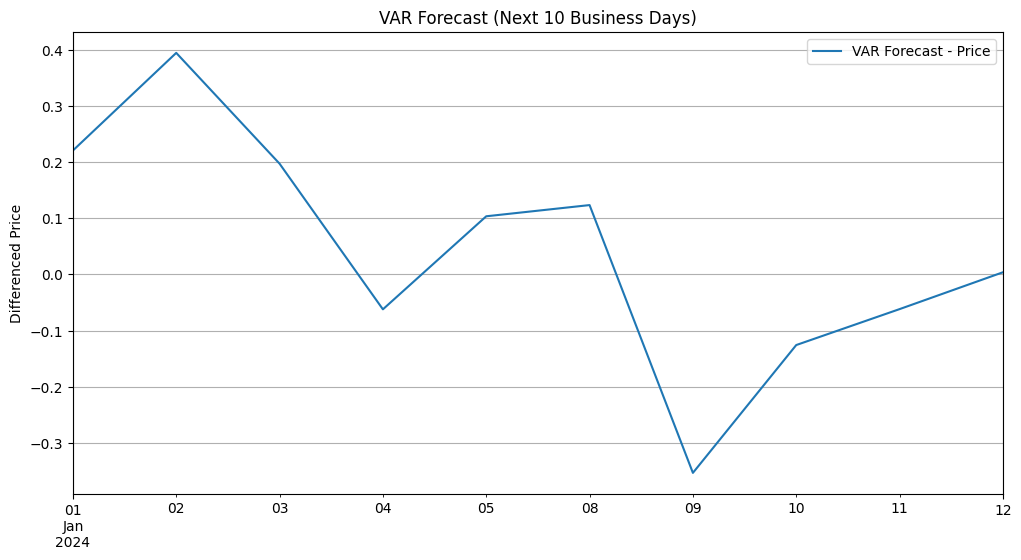

In [3]:
# Time Series Forecasting: Google Stock Data (GOOG)

# 1. SETUP AND DATA DOWNLOAD
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.api import VAR
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Download Google stock price data
data = yf.download('GOOG', start='2015-01-01', end='2024-01-01')
data = data[['Close']].dropna()
data.columns = ['Price']

plt.figure(figsize=(12, 6))
data.plot(title='GOOG Stock Closing Price', legend=True)
plt.ylabel("Price")
plt.grid()
plt.show()

# 2. NAIVE FORECAST
data['Naive'] = data['Price'].shift(1)
data[['Price', 'Naive']].plot(title='Naive Forecast', figsize=(12, 6))
plt.ylabel("Price")
plt.grid()
plt.show()

# 3. SEASONAL NAIVE FORECAST
season_length = 5  # assuming weekly seasonality

data['SeasonalNaive'] = data['Price'].shift(season_length)
data[['Price', 'SeasonalNaive']].plot(title='Seasonal Naive Forecast', figsize=(12, 6))
plt.ylabel("Price")
plt.grid()
plt.show()

# 4. AVERAGE FORECAST
data['Average'] = data['Price'].expanding().mean()
data[['Price', 'Average']].plot(title='Average Forecast', figsize=(12, 6))
plt.ylabel("Price")
plt.grid()
plt.show()

# 5. SEASONALITY ANALYSIS
from pandas.plotting import autocorrelation_plot

plt.figure(figsize=(10, 5))
autocorrelation_plot(data['Price'])
plt.title("Autocorrelation Plot - Seasonality Analysis")
plt.grid()
plt.show()

# 6. DECOMPOSITION
result = seasonal_decompose(data['Price'], model='additive', period=30)
result.plot()
plt.suptitle("Seasonal Decomposition", fontsize=14)
plt.show()

# 7. STATIONARITY CHECK
result_adf = adfuller(data['Price'].dropna())
print("ADF Statistic:", result_adf[0])
print("p-value:", result_adf[1])

if result_adf[1] > 0.05:
    print("\nSeries is NOT stationary. Differencing applied.\n")
    data['Price_diff'] = data['Price'].diff().dropna()
else:
    print("\nSeries is stationary.\n")
    data['Price_diff'] = data['Price']

plt.figure(figsize=(12, 6))
data['Price_diff'].dropna().plot(title="Transformed Series (Stationary)")
plt.grid()
plt.show()

# 7a. ACF and PACF plots for model diagnostics
plt.figure(figsize=(12, 5))
plot_acf(data['Price_diff'].dropna(), lags=50)
plt.title("Autocorrelation Function (ACF) of Stationary Series")
plt.show()

plt.figure(figsize=(12, 5))
plot_pacf(data['Price_diff'].dropna(), lags=50, method='ywm')
plt.title("Partial Autocorrelation Function (PACF) of Stationary Series")
plt.show()

# Explanation:
# - ACF helps identify the order of MA(q): significant spikes in lags indicate q.
# - PACF helps identify the order of AR(p): significant spikes in lags indicate p.
# These are useful for choosing parameters in ARIMA(p,d,q).

# 8. EXPONENTIAL SMOOTHING
model_exp = ExponentialSmoothing(data['Price'], trend='add', seasonal=None)
fit_exp = model_exp.fit()
data['ExpSmoothing'] = fit_exp.fittedvalues

plt.figure(figsize=(12, 6))
data[['Price', 'ExpSmoothing']].plot(title='Exponential Smoothing Forecast')
plt.grid()
plt.show()

# 9. ARIMA MODELING
train = data['Price_diff'].dropna()[:-100]
test = data['Price_diff'].dropna()[-100:]

model_arima = ARIMA(train, order=(5, 1, 0))
fit_arima = model_arima.fit()
pred_arima = fit_arima.forecast(steps=100)

plt.figure(figsize=(12, 6))
plt.plot(test.index, test.values, label='Actual')
plt.plot(test.index, pred_arima, label='ARIMA Forecast')
plt.title("ARIMA Forecast on Stationary Series")
plt.ylabel("Differenced Price")
plt.legend()
plt.grid()
plt.show()

# 10. LSTM FORECAST
# Normalize data
scaler = MinMaxScaler()
data['Scaled'] = scaler.fit_transform(data[['Price']])

# Sequence data
def create_sequences(data, seq_length):
    x, y = [], []
    for i in range(len(data)-seq_length):
        x.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(x), np.array(y)

seq_len = 30
seq_data = data['Scaled'].dropna().values
X, y = create_sequences(seq_data, seq_len)
X = X.reshape((X.shape[0], X.shape[1], 1))

model_lstm = Sequential([
    LSTM(50, activation='relu', input_shape=(seq_len, 1)),
    Dense(1)
])
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(X, y, epochs=5, verbose=1)

preds = model_lstm.predict(X)
preds_inv = scaler.inverse_transform(preds)

plt.figure(figsize=(12, 6))
plt.plot(data.index[seq_len:], data['Price'].values[seq_len:], label='Actual')
plt.plot(data.index[seq_len:], preds_inv, label='LSTM Forecast')
plt.title("LSTM Forecast")
plt.ylabel("Price")
plt.legend()
plt.grid()
plt.show()

# 11. MULTIVARIATE TIME SERIES (e.g. with Volume)
data_multi = yf.download('GOOG', start='2015-01-01', end='2024-01-01')[['Close', 'Volume']].dropna()
data_multi.columns = ['Price', 'Volume']
data_multi = data_multi.diff().dropna()

# 12. VAR MODEL
model_var = VAR(data_multi)
fit_var = model_var.fit(maxlags=15, ic='aic')
pred_var = fit_var.forecast(fit_var.endog, steps=10)

forecast_index = pd.date_range(start=data_multi.index[-1], periods=11, freq='B')[1:]
forecast_df = pd.DataFrame(pred_var, index=forecast_index, columns=['Price', 'Volume'])

plt.figure(figsize=(12, 6))
forecast_df['Price'].plot(label='VAR Forecast - Price')
plt.title("VAR Forecast (Next 10 Business Days)")
plt.ylabel("Differenced Price")
plt.grid()
plt.legend()
plt.show()


Evaluating different ARIMA(p,d,q) configurations:

ARIMA(1,0,0) - MSE: 5.0843
ARIMA(1,0,1) - MSE: 5.0810
ARIMA(1,0,2) - MSE: 5.0810
ARIMA(1,1,0) - MSE: 6.1080
ARIMA(1,1,1) - MSE: 5.0843
ARIMA(1,1,2) - MSE: 5.0777
ARIMA(2,0,0) - MSE: 5.0832
ARIMA(2,0,1) - MSE: 5.0810
ARIMA(2,0,2) - MSE: 5.0826
ARIMA(2,1,0) - MSE: 6.0348
ARIMA(2,1,1) - MSE: 5.0833
ARIMA(2,1,2) - MSE: 5.0767
ARIMA(5,0,0) - MSE: 5.0902
ARIMA(5,0,1) - MSE: 5.0898
ARIMA(5,0,2) - MSE: 4.9053
ARIMA(5,1,0) - MSE: 5.1661
ARIMA(5,1,1) - MSE: 5.0902
ARIMA(5,1,2) - MSE: 5.0774


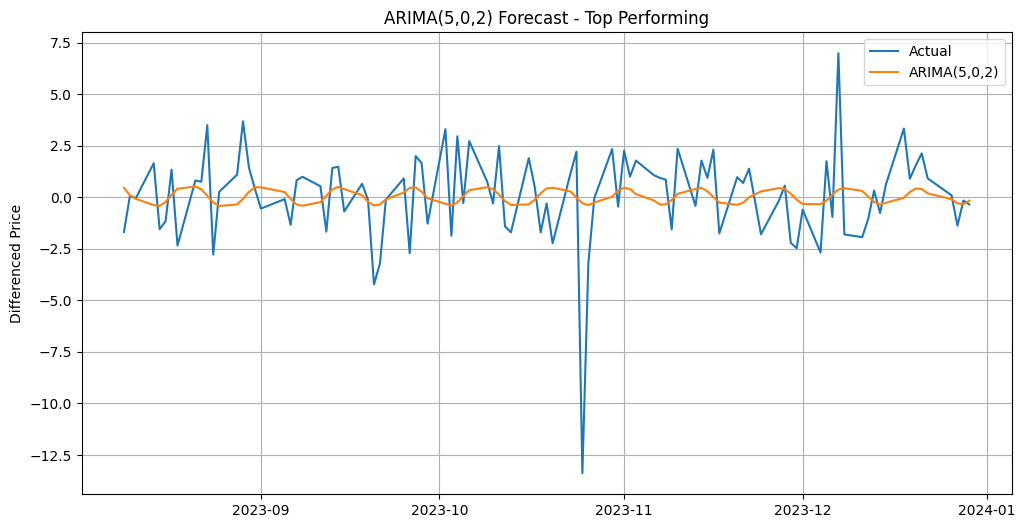

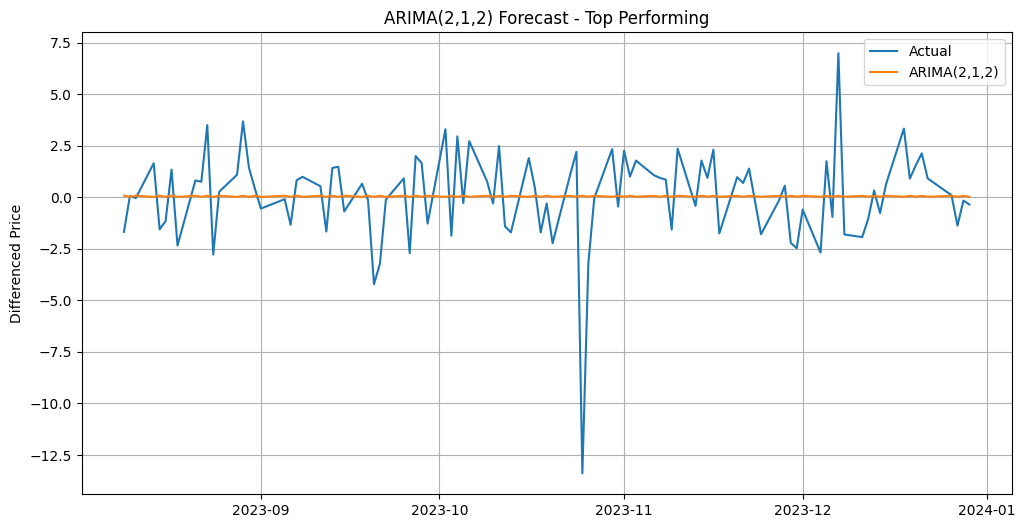

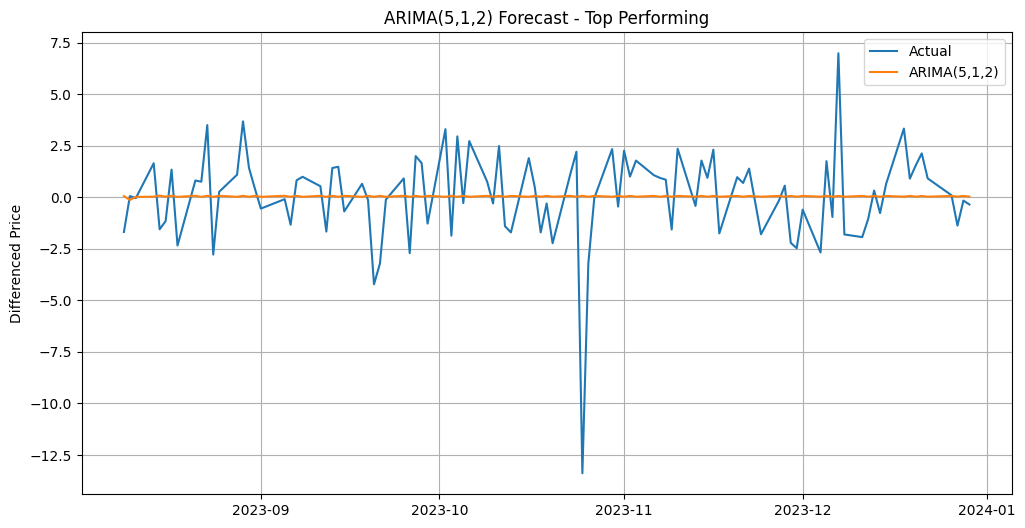

In [4]:
# Time Series Forecasting: Google Stock Data (GOOG)

# ... [previous content remains unchanged]

# 9b. Experimenting with Different ARIMA (p,d,q) Settings
# This block allows students to test multiple ARIMA configurations and observe results
from sklearn.metrics import mean_squared_error
import itertools

# Define parameter grid
p_values = [1, 2, 5]
d_values = [0, 1]
q_values = [0, 1, 2]

results = []

print("\nEvaluating different ARIMA(p,d,q) configurations:\n")
for p, d, q in itertools.product(p_values, d_values, q_values):
    try:
        model = ARIMA(train, order=(p, d, q))
        fit = model.fit()
        forecast = fit.forecast(steps=100)
        error = mean_squared_error(test, forecast)
        results.append(((p, d, q), error))
        print(f"ARIMA({p},{d},{q}) - MSE: {error:.4f}")
    except Exception as e:
        print(f"ARIMA({p},{d},{q}) - Failed: {e}")

# Plot top 3 models
results.sort(key=lambda x: x[1])
top_models = results[:3]

for (p, d, q), _ in top_models:
    model = ARIMA(train, order=(p, d, q))
    fit = model.fit()
    forecast = fit.forecast(steps=100)
    plt.figure(figsize=(12, 6))
    plt.plot(test.index, test.values, label='Actual')
    plt.plot(test.index, forecast, label=f'ARIMA({p},{d},{q})')
    plt.title(f"ARIMA({p},{d},{q}) Forecast - Top Performing")
    plt.ylabel("Differenced Price")
    plt.legend()
    plt.grid()
    plt.show()

# [Continue with LSTM and remaining content below...]



Training LSTM with window size = 10
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


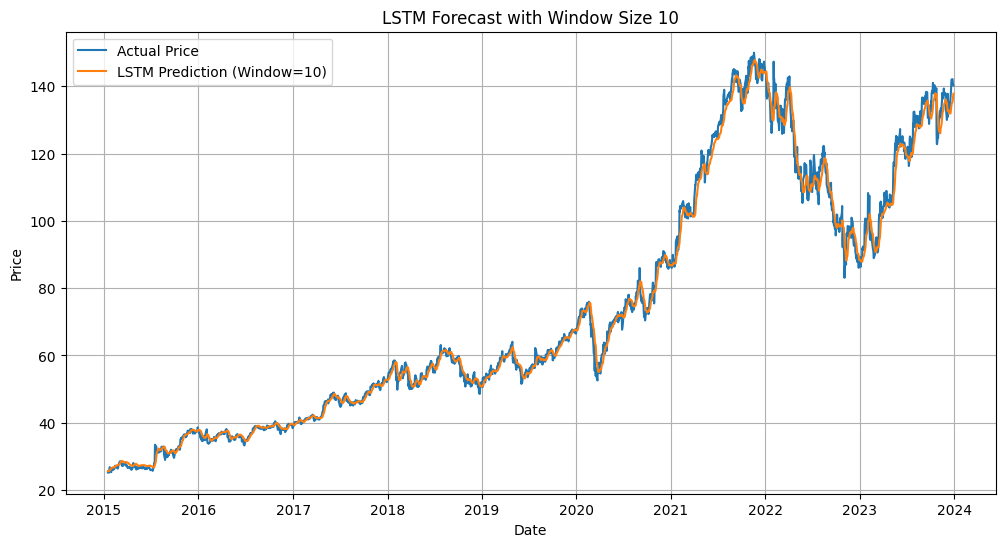


Training LSTM with window size = 30
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


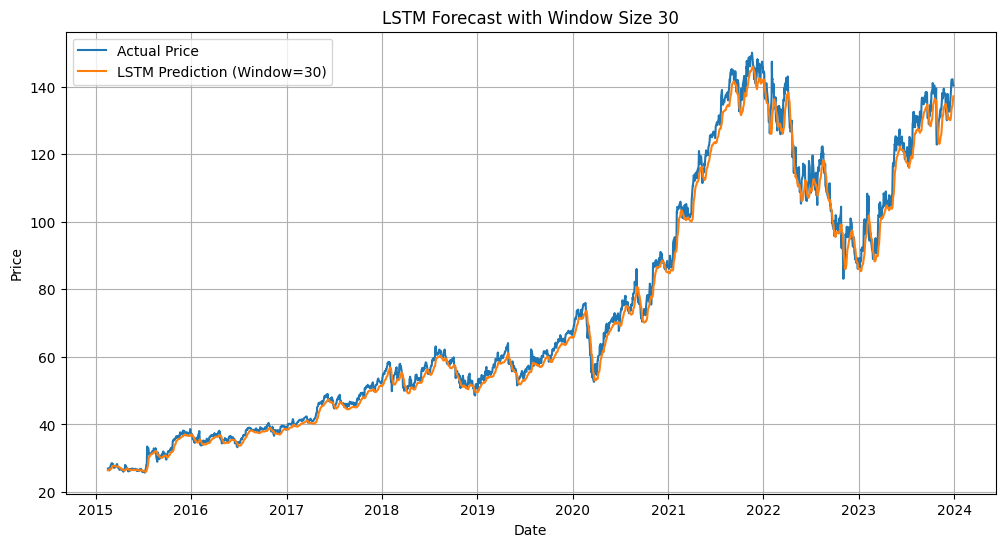


Training LSTM with window size = 60
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


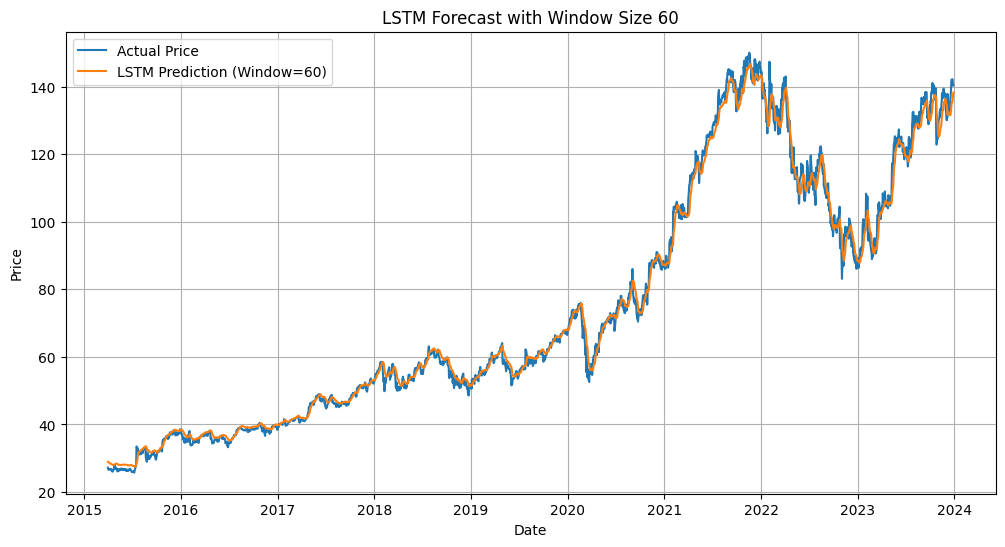

In [6]:
# Time Series Forecasting: Google Stock Data (GOOG)

# ... [previous content remains unchanged]

# 9b. Experimenting with Different ARIMA (p,d,q) Settings
# ... [same content as before]

# 10. LSTM FORECAST (continued)
# Normalize data again for LSTM
scaler = MinMaxScaler()
data['Scaled'] = scaler.fit_transform(data[['Price']])

# Create sequences for supervised learning
def create_sequences(data, seq_length):
    x, y = [], []
    for i in range(len(data)-seq_length):
        x.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(x), np.array(y)

# Try LSTM with different window sizes
window_sizes = [10, 30, 60]

for seq_len in window_sizes:
    print(f"\nTraining LSTM with window size = {seq_len}")
    seq_data = data['Scaled'].dropna().values
    X, y = create_sequences(seq_data, seq_len)
    X = X.reshape((X.shape[0], X.shape[1], 1))

    # Build and train LSTM model
    model_lstm = Sequential([
        LSTM(50, activation='relu', input_shape=(seq_len, 1)),
        Dense(1)
    ])
    model_lstm.compile(optimizer='adam', loss='mse')
    model_lstm.fit(X, y, epochs=10, batch_size=32, verbose=0)

    # Generate predictions
    preds = model_lstm.predict(X)
    preds_inv = scaler.inverse_transform(preds)

    # Plot results
    plt.figure(figsize=(12, 6))
    plt.plot(data.index[seq_len:], data['Price'].values[seq_len:], label='Actual Price')
    plt.plot(data.index[seq_len:], preds_inv, label=f'LSTM Prediction (Window={seq_len})')
    plt.title(f"LSTM Forecast with Window Size {seq_len}")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid()
    plt.show()



Training LSTM with window size = 10
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


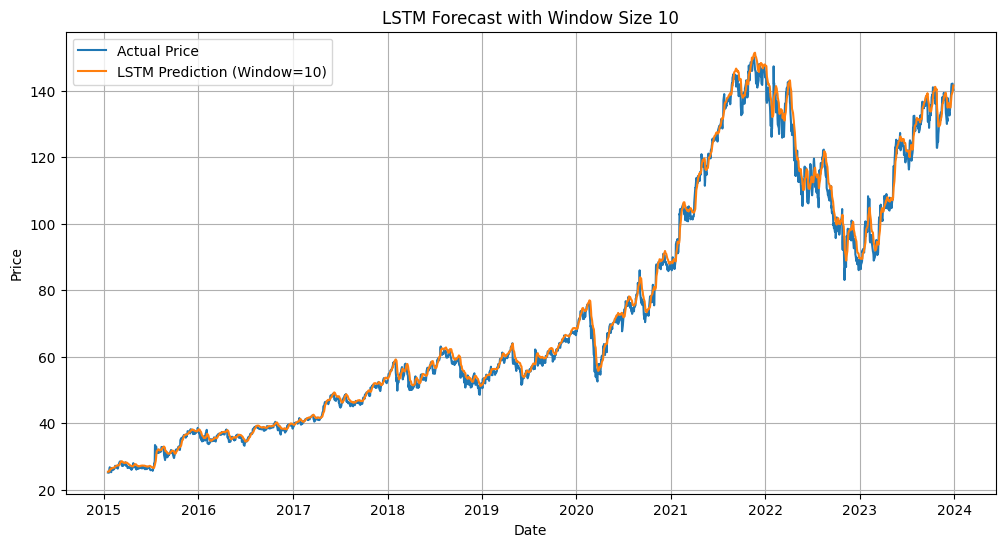


Training LSTM with window size = 30
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


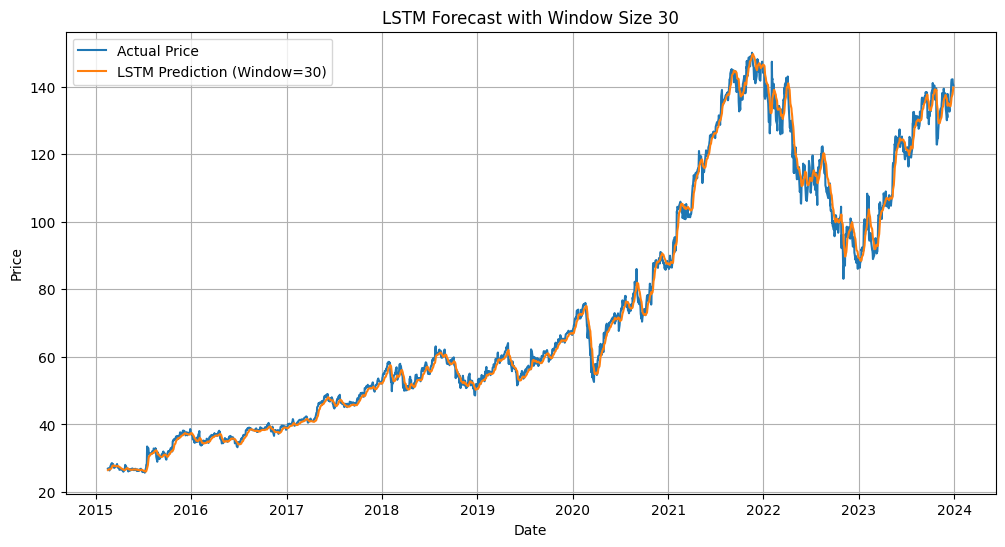


Training LSTM with window size = 60
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


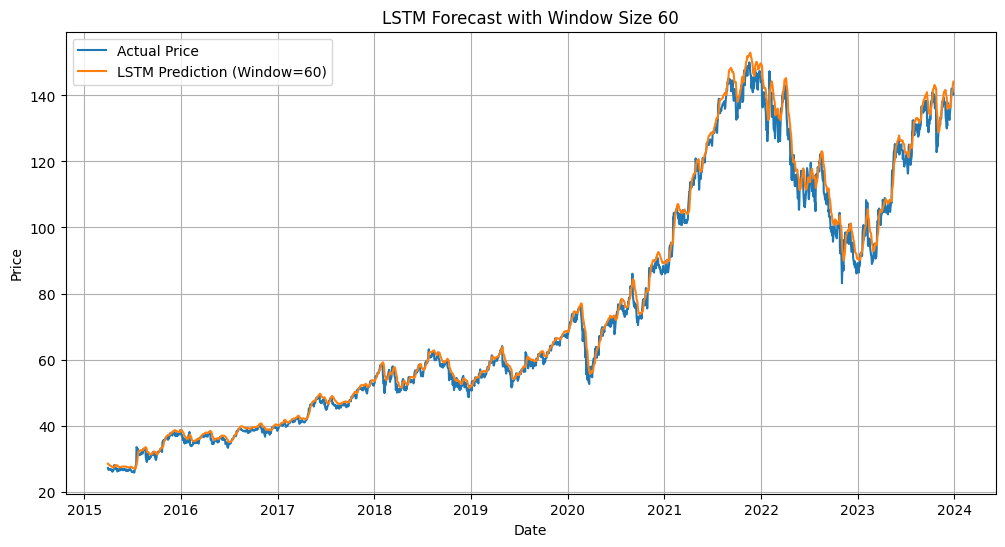


LSTM Evaluation Results:
Window Size 10 -> MSE: 6.2078, MAE: 1.6647
Window Size 30 -> MSE: 6.5403, MAE: 1.7636
Window Size 60 -> MSE: 8.1322, MAE: 1.9426


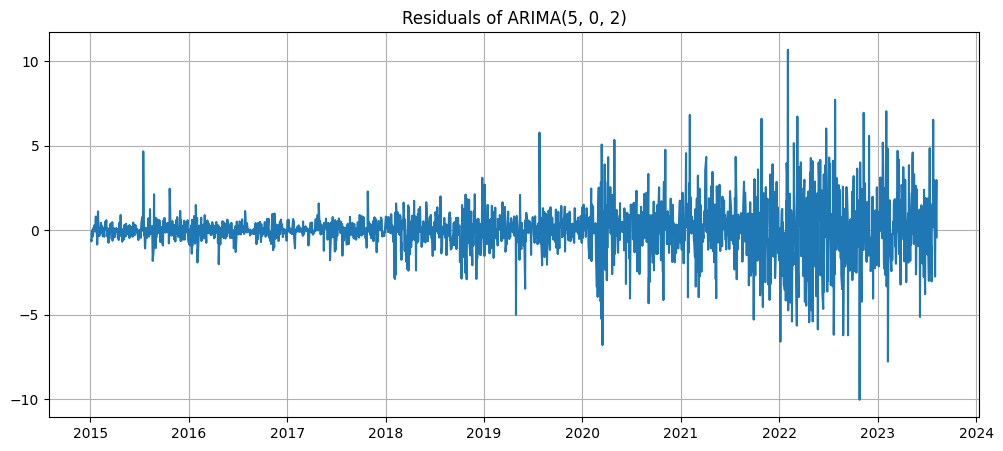

<Figure size 1200x500 with 0 Axes>

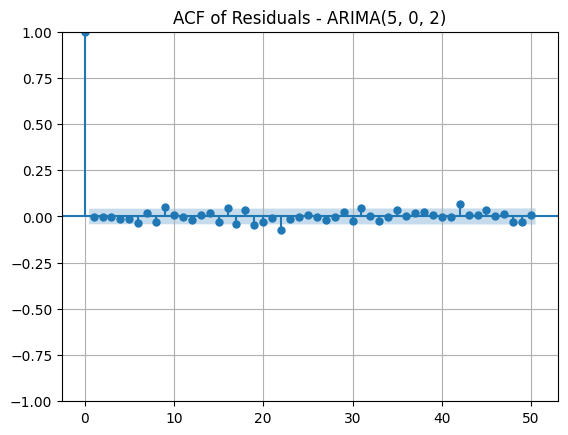


Walk-forward validation (ARIMA)


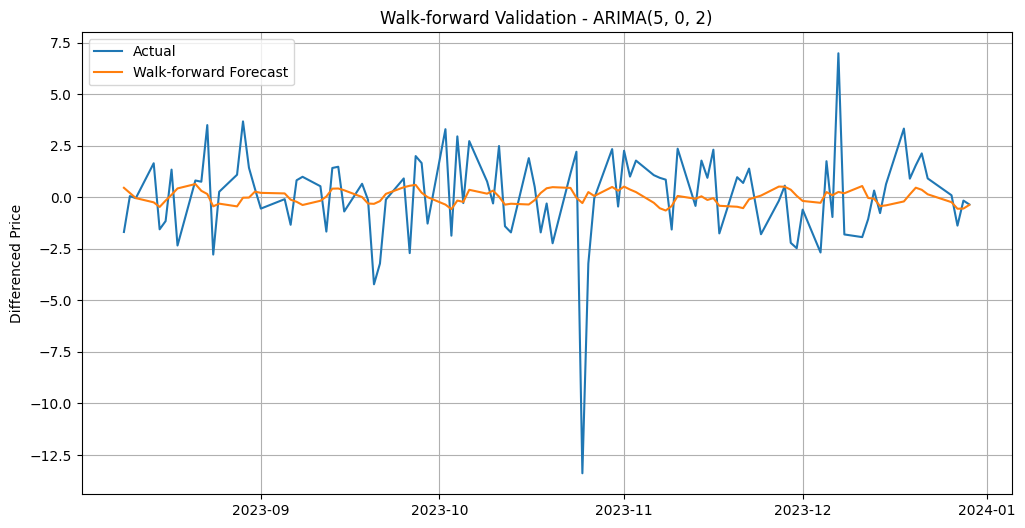

[*********************100%***********************]  1 of 1 completed

Walk-forward MSE: 4.9745, MAE: 1.5624


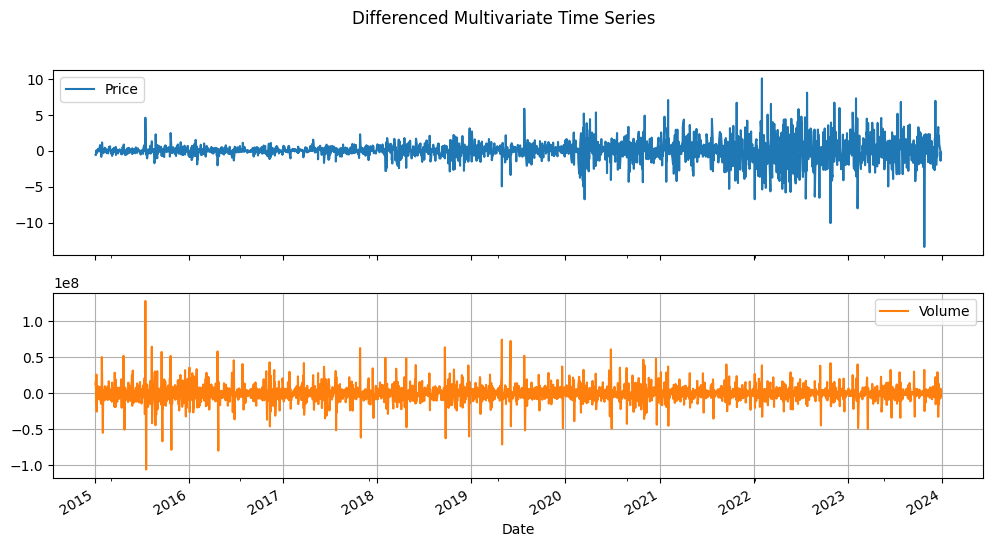

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 03, Apr, 2025
Time:                     00:54:09
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    33.6714
Nobs:                     2218.00    HQIC:                   33.5701
Log likelihood:          -43397.1    FPE:                3.58124e+14
AIC:                      33.5119    Det(Omega_mle):     3.48319e+14
--------------------------------------------------------------------
Results for equation Price
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
const              0.062096         0.032572            1.906           0.057
L1.Price          -0.038079         0.021400           -1.779           0.075
L1.Volume          0.000000         0.000000            0.090           

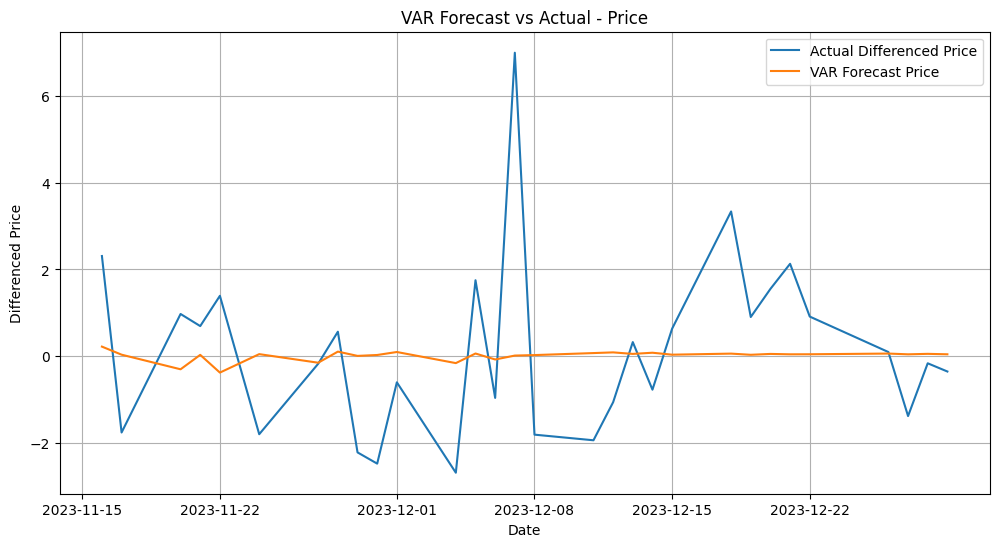

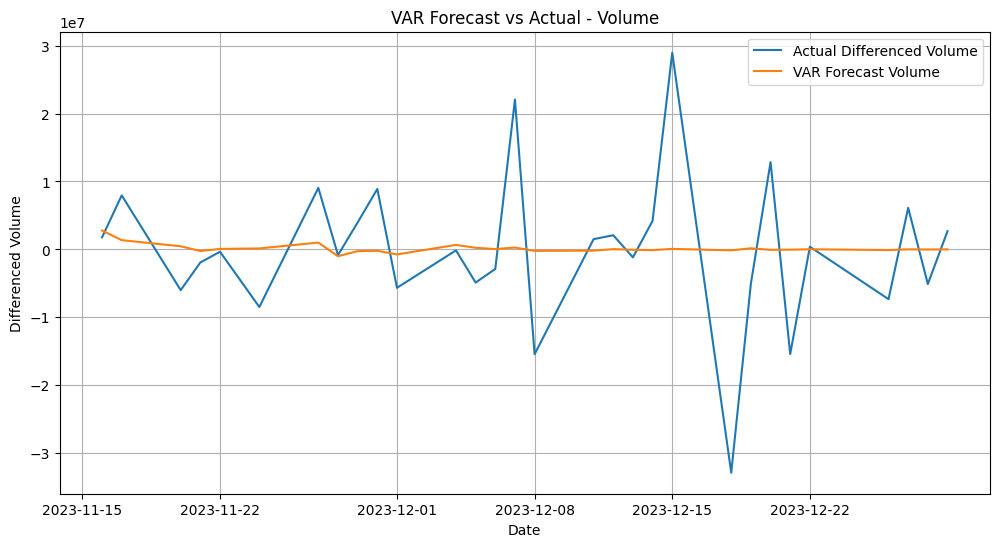

VAR Price MSE: 3.9136, Volume MSE: 119307555642652.1562


In [7]:
# Time Series Forecasting: Google Stock Data (GOOG)

# ... [previous content remains unchanged]

# 9b. Experimenting with Different ARIMA (p,d,q) Settings
# ... [same content as before]

# 10. LSTM FORECAST (continued)
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Normalize data again for LSTM
scaler = MinMaxScaler()
data['Scaled'] = scaler.fit_transform(data[['Price']])

# Create sequences for supervised learning
def create_sequences(data, seq_length):
    x, y = [], []
    for i in range(len(data)-seq_length):
        x.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(x), np.array(y)

# Try LSTM with different window sizes
window_sizes = [10, 30, 60]

lstm_results = []

for seq_len in window_sizes:
    print(f"\nTraining LSTM with window size = {seq_len}")
    seq_data = data['Scaled'].dropna().values
    X, y = create_sequences(seq_data, seq_len)
    X = X.reshape((X.shape[0], X.shape[1], 1))

    # Build and train LSTM model
    model_lstm = Sequential([
        LSTM(50, activation='relu', input_shape=(seq_len, 1)),
        Dense(1)
    ])
    model_lstm.compile(optimizer='adam', loss='mse')
    model_lstm.fit(X, y, epochs=10, batch_size=32, verbose=0)

    # Generate predictions
    preds = model_lstm.predict(X)
    preds_inv = scaler.inverse_transform(preds)
    y_true = data['Price'].values[seq_len:]

    # Evaluation metrics
    mse = mean_squared_error(y_true, preds_inv)
    mae = mean_absolute_error(y_true, preds_inv)
    lstm_results.append((seq_len, mse, mae))

    # Plot results
    plt.figure(figsize=(12, 6))
    plt.plot(data.index[seq_len:], y_true, label='Actual Price')
    plt.plot(data.index[seq_len:], preds_inv, label=f'LSTM Prediction (Window={seq_len})')
    plt.title(f"LSTM Forecast with Window Size {seq_len}")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid()
    plt.show()

# Print summary of LSTM results
print("\nLSTM Evaluation Results:")
for window, mse, mae in lstm_results:
    print(f"Window Size {window} -> MSE: {mse:.4f}, MAE: {mae:.4f}")

# 11. Residual Diagnostics for ARIMA (best model from earlier)
from statsmodels.graphics.tsaplots import plot_acf

best_order = top_models[0][0]
fit_best_arima = ARIMA(train, order=best_order).fit()
residuals = fit_best_arima.resid

plt.figure(figsize=(12, 5))
plt.plot(residuals)
plt.title(f"Residuals of ARIMA{best_order}")
plt.grid()
plt.show()

plt.figure(figsize=(12, 5))
plot_acf(residuals, lags=50)
plt.title(f"ACF of Residuals - ARIMA{best_order}")
plt.grid()
plt.show()

# 12. Walk-forward validation (rolling forecast origin)
print("\nWalk-forward validation (ARIMA)")
temp_train = list(train)
temp_test = list(test)
preds_walk = []

for t in range(len(temp_test)):
    model = ARIMA(temp_train, order=best_order)
    fit = model.fit()
    yhat = fit.forecast()[0]
    preds_walk.append(yhat)
    temp_train.append(temp_test[t])

walk_mse = mean_squared_error(temp_test, preds_walk)
walk_mae = mean_absolute_error(temp_test, preds_walk)

plt.figure(figsize=(12, 6))
plt.plot(test.index, test.values, label='Actual')
plt.plot(test.index, preds_walk, label='Walk-forward Forecast')
plt.title(f"Walk-forward Validation - ARIMA{best_order}")
plt.ylabel("Differenced Price")
plt.legend()
plt.grid()
plt.show()

print(f"Walk-forward MSE: {walk_mse:.4f}, MAE: {walk_mae:.4f}")

# 13. Multivariate Time Series Forecasting with VAR

# Re-download Google stock data with Price and Volume
multi_data = yf.download('GOOG', start='2015-01-01', end='2024-01-01')[['Close', 'Volume']].dropna()
multi_data.columns = ['Price', 'Volume']

# Take first differences to induce stationarity
multi_diff = multi_data.diff().dropna()

# Plot to inspect
multi_diff.plot(subplots=True, figsize=(12, 6), title='Differenced Multivariate Time Series')
plt.grid()
plt.show()

# Train-test split
n_obs = 30  # forecast 30 days
train_multi = multi_diff[:-n_obs]
test_multi = multi_diff[-n_obs:]

# Fit VAR model
model_var = VAR(train_multi)
fit_var = model_var.fit(maxlags=15, ic='aic')
print(fit_var.summary())

# Forecast
forecast = fit_var.forecast(train_multi.values, steps=n_obs)
forecast_index = test_multi.index
forecast_df = pd.DataFrame(forecast, index=forecast_index, columns=['Price_forecast', 'Volume_forecast'])

# Plot forecast vs actual for Price
plt.figure(figsize=(12, 6))
plt.plot(test_multi.index, test_multi['Price'], label='Actual Differenced Price')
plt.plot(forecast_index, forecast_df['Price_forecast'], label='VAR Forecast Price')
plt.title("VAR Forecast vs Actual - Price")
plt.xlabel("Date")
plt.ylabel("Differenced Price")
plt.legend()
plt.grid()
plt.show()

# Plot forecast vs actual for Volume
plt.figure(figsize=(12, 6))
plt.plot(test_multi.index, test_multi['Volume'], label='Actual Differenced Volume')
plt.plot(forecast_index, forecast_df['Volume_forecast'], label='VAR Forecast Volume')
plt.title("VAR Forecast vs Actual - Volume")
plt.xlabel("Date")
plt.ylabel("Differenced Volume")
plt.legend()
plt.grid()
plt.show()

# Evaluate
price_mse = mean_squared_error(test_multi['Price'], forecast_df['Price_forecast'])
volume_mse = mean_squared_error(test_multi['Volume'], forecast_df['Volume_forecast'])
print(f"VAR Price MSE: {price_mse:.4f}, Volume MSE: {volume_mse:.4f}")
